# Demonstrate player localization (and pose estimation)

Simplified version of the joint trajectories processing: Only localization is demonstrated, no dynamic ROI is used, no smoothing etc.

In [27]:
import numpy as np
import cv2
import ast
import os
import matplotlib.pylab as plt

In [47]:
from pose_estimation_script import handle_one
print('warming up')
_ = handle_one(np.ones((320,320,3)))

warming up


/Users/ninawiedemann/anaconda/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:183: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.")


## Specify data, target player and which joints to include for localization

If no dat file is available and no ROI should be used in the first frame, put "" as path_to_ROI and specify center (the position of the target player in the first frame)

In [72]:
# In example_1 localization works well, in example_2 the player is lost because pose estimation is too inaccurate
path_to_video = os.path.join("..", "demo_data", "example_2.mp4")
path_to_ROI = os.path.join("..", "demo_data", "example_2.mp4.dat")
# CENTER =  # if no ROI available, specify coordinates of the target player in the first frame
target_player = "Batter"
important_joints = [0,3,6,7,8,9,10,11] # only hips, shoulders, knees and ankles (most stable joints)
hips = [6,9] # for first position
START_VIDEO_AT_FRAME = 70 # usually in the first 70 frames not much is happening

## Localization functions

In [70]:
def overlap(A, B):
    """
    returns IoU of two rectangles A and B (if no overlap, returns 0)
    """
    # if no overlap
    if (A[0] > B[1]) or (A[1] < B[0]):
        return 0
    if (A[2] > B[3]) or (A[3] < B[2]):
        return 0
    # else calculate areas
    I = [max(A[0], B[0]), min(A[1], B[1]), max(A[2], B[2]), min(A[3], B[3])]
    # cv2.rectangle(frame, tuple(np.asarray(I)[[0,2]].astype(int)), tuple(np.asarray(I)[[1,3]].astype(int)),[0,0,255], 4)
    Aarea = abs((A[0]-A[1])*(A[2]-A[3]))
    Barea = abs((B[0]-B[1])*(B[2]-B[3]))
    Iarea = abs((I[0]-I[1])*(I[2]-I[3]))
    return Iarea/(Aarea+Barea-Iarea)

def player_localization(joints ,old_array, frame, low_thresh=0.1, higher_tresh = 0.5):
    """
    returns an array containing only the coordinates of the target person, based on the previous location in old_array, and
    the possible detections in joints
    joints: current detections - array of shape number_people_detected * number_joints * number_coordinates
    old_array: located detection in previous frame, array of shape number_joints * number_coordinates
    low_thresh: minimum IoU value
    higher_thresh: if more than one person has a IoU>higher_tresh with the previous detection, the people seem to be confused - missing frame
    """
    plt.figure()
    
    joints = np.asarray(joints)
    non_zero_target = np.where(old_array[:,0]!=0)[0]
    joints_for_bbox = np.intersect1d(non_zero_target, important_joints) # non missing important values of previous frame
    old_arr_bbox = [np.min(old_array[joints_for_bbox, 0]), np.max(old_array[joints_for_bbox, 0]),
                   np.min(old_array[joints_for_bbox, 1]), np.max(old_array[joints_for_bbox, 1])] # bbox of previous frame detecten of target person
    intersections = []
    dist = []
    
    # check all detected persons
    for i in range(np.asarray(joints).shape[0]):
        player_array = joints[i]

        non_zerrow_person =np.where(np.asarray(joints)[i,:,0]!=0)[0] # nonzero current person
        non_zero_person_and_target =np.intersect1d(non_zerrow_person,non_zero_target) # nonzero current and previous
        non_zerrow_important = np.intersect1d(non_zero_person_and_target, important_joints) # important joint and not missing in previous and current person
        joints_for_bbox = np.intersect1d(non_zerrow_person, important_joints) # intersection of important non-missing values of current person

        if len(non_zerrow_important)<3: # not enough joints detected
            intersections.append(0)
            dist.append(np.inf)
            continue
        dist.append(np.linalg.norm(joints[i,non_zerrow_important,:] - old_array[non_zerrow_important,:])/len(non_zerrow_important)) # eucledian distance between all joints, normalized to mean distance per joint
        # bbbox aound current person
        player_arr_bbox = [np.min(player_array[joints_for_bbox, 0]), np.max(player_array[joints_for_bbox, 0]),
                        np.min(player_array[joints_for_bbox, 1]), np.max(player_array[joints_for_bbox, 1])]
        # plot
        cv2.rectangle(frame, tuple(np.asarray(player_arr_bbox)[[0,2]].astype(int)), tuple(np.asarray(player_arr_bbox)[[1,3]].astype(int)),[0,255,0], 4)
        # calculate IoU
        intersections.append(overlap(player_arr_bbox, old_arr_bbox)) # IoU of bbox of current and previous detetcon
    
    print("Overlaps (IoU):", intersections)
    
    # cases where we set frame to zeros (missing values):
    # if no person detected at all
    # if no person is intersection more than IoU = low_thresh
    # if two in intersections are bigger than higher_tresh (because if two guys overlaping that much, it is better to set it as missing value than to take the guy with most)
    if len(intersections)==0 or np.all(np.array(intersections)<low_thresh) or np.sum(np.array(intersections)>higher_tresh)>1: # player seem to be significantly overlapping
        print("missing frame because of not enough or too many intersections", "with intersections:", intersections) #, "with players", df[player][frame])
        res = np.array([[0,0] for i in range(18)])
    else:
        # --- FIRST VERSION: simply take the one with highest intersection
        target = np.argmax(intersections)
        # print("taken index from distances:", target)
        res = joints[target]
        # --- SECOND VERSION: minimum of distance of joints is taken as target, if IoU>0.1 (to prevent it from picking up simply the closest person in a missing frame ----
        #np.argmin(dist)
        # --- THIRD VERSION: minimum of distance of joints is taken as target, but only if it corresponds to the maximum of IoU ----
        # if np.argmax(intersections) == target:
        #     res = handle_one[target]
        # else:
        #     print("missing frame: maximum von intesections is different from minimum of distances", intersections, dist)
        #     res = np.array([[0,0] for i in range(18)])
    cv2.rectangle(frame, tuple(np.asarray(old_arr_bbox)[[0,2]].astype(int)), tuple(np.asarray(old_arr_bbox)[[1,3]].astype(int)),[255,0,0], 4)
    plt.imshow(frame)
    plt.show()
    return res


## Run on video

See comments to show not only the bounding boxes, but the sceleton output of pose estimation

### Green rectangles: All detected people
### Red rectangle: Localized target player (in previous frame)

ROI: 269 499 703 103


/Users/ninawiedemann/anaconda/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:183: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.")


Frame 0
Frame 1
Overlaps (IoU): [0, 0.92702903946388682, 0]


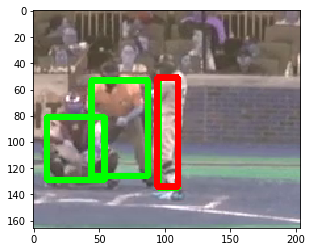

Frame 2
Overlaps (IoU): [0, 0.9375, 0, 0]


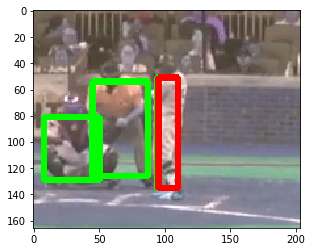

Frame 3
Overlaps (IoU): [0, 0.94117647058823528, 0]


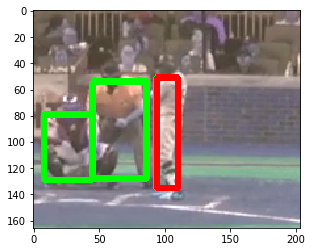

/Users/ninawiedemann/Desktop/UNI/Praktikum/ALL/1_Pose_Estimation/pose_estimation_script.py:310: RuntimeWarning: invalid value encountered in true_divide
  startend = zip(np.linspace(candA[i][0], candB[j][0], num=mid_num), \
/Users/ninawiedemann/Desktop/UNI/Praktikum/ALL/1_Pose_Estimation/pose_estimation_script.py:329: RuntimeWarning: invalid value encountered in greater
  if criterion1 and criterion2:


Frame 4
Overlaps (IoU): [0.94117647058823528, 0, 0, 0]


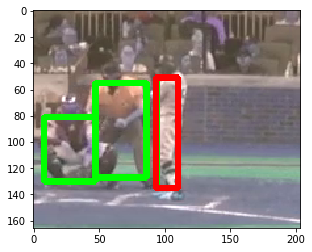

Frame 5
Overlaps (IoU): [0, 0, 0.9375]


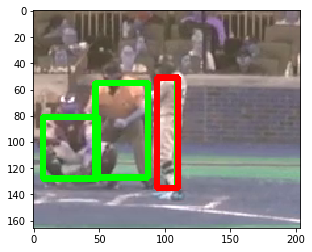

Frame 6
Overlaps (IoU): [0, 0, 0.9375]


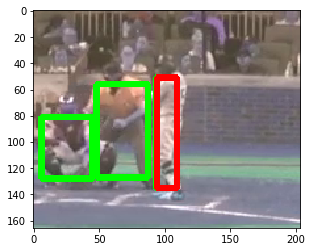

Frame 7
Overlaps (IoU): [0, 1.0, 0, 0]


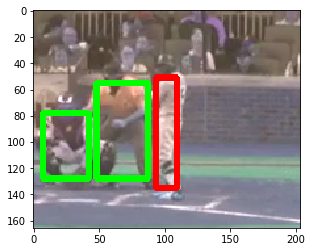

Frame 8
Overlaps (IoU): [0, 0.9375, 0, 0, 0]


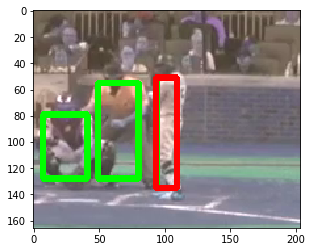

Frame 9
Overlaps (IoU): [1.0, 0, 0, 0]


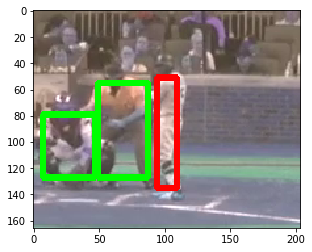

Frame 10
Overlaps (IoU): [1.0, 0, 0, 0]


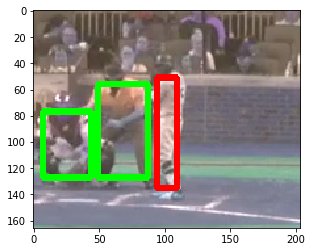

Frame 11
Overlaps (IoU): [1.0, 0, 0, 0]


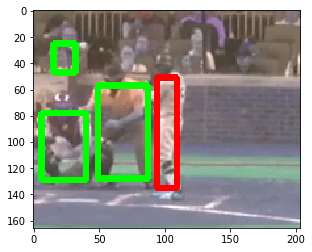

Frame 12
Overlaps (IoU): [0.8666666666666667, 0, 0, 0, 0, 0]


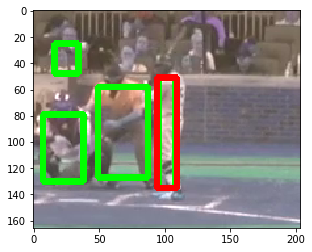

Frame 13
Overlaps (IoU): [0, 0.9882352941176471, 0, 0, 0]


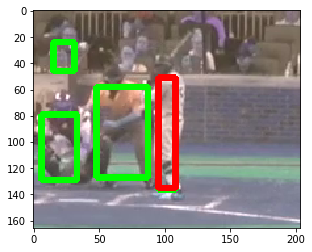

Frame 14
Overlaps (IoU): [0, 0, 0.98837209302325579, 0]


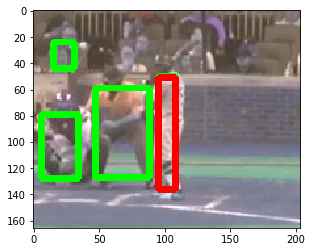

Frame 15
Overlaps (IoU): [0, 0, 0.91853699085619289, 0]


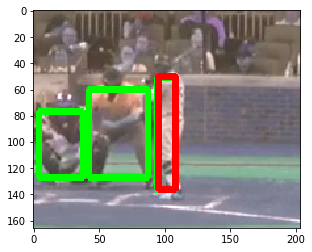

Frame 16
Overlaps (IoU): [0, 1.0, 0, 0]


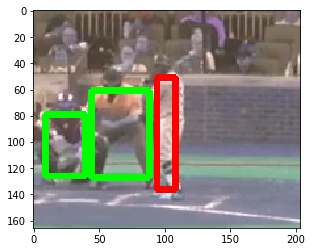

Frame 17
Overlaps (IoU): [0, 0, 0.93333333333333335, 0]


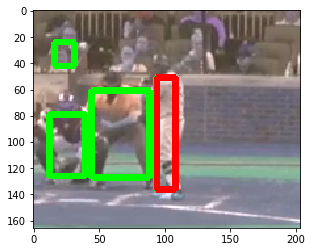

Frame 18
Overlaps (IoU): [0, 0, 0.8666666666666667, 0]


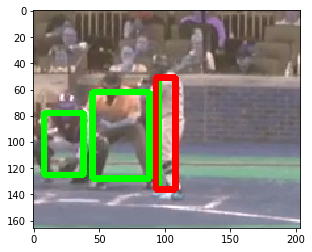

Frame 19
Overlaps (IoU): [0, 0, 0.9285714285714286, 0]


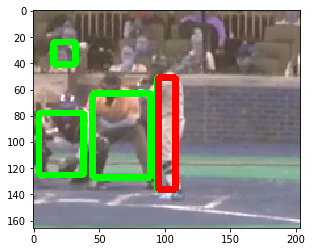

Frame 20
Overlaps (IoU): [0, 0, 0.9882352941176471, 0]


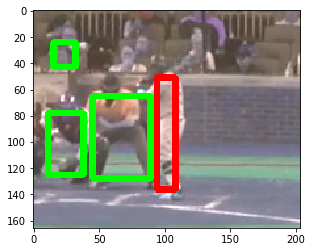

Frame 21
Overlaps (IoU): [0, 0, 0.8571428571428571, 0]


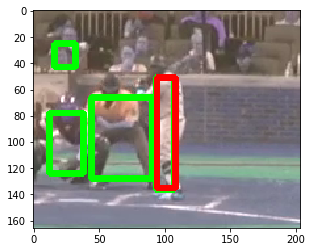

Frame 22
Overlaps (IoU): [0, 0, 0.84705882352941175, 0, 0, 0]


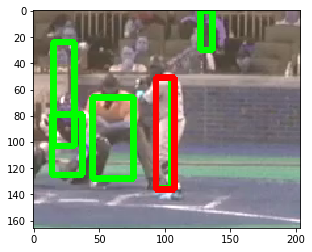

Frame 23
Overlaps (IoU): [0, 0, 0.84615384615384615, 0, 0, 0]


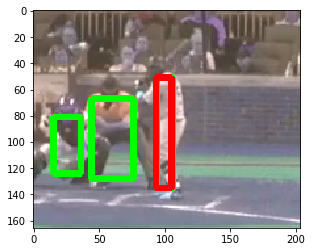

Frame 24
Overlaps (IoU): [0, 0, 0.69992972593113145, 0]


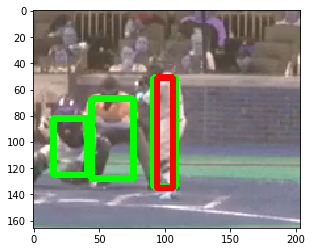

Frame 25
Overlaps (IoU): [0, 0, 0.72588297311544547, 0, 0]


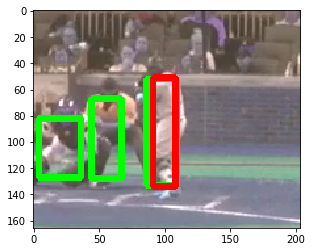

Frame 26
Overlaps (IoU): [0.11177644710578842, 0, 0.78529253891572737, 0]


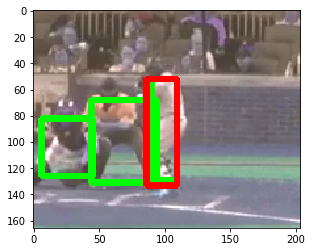

Frame 27
Overlaps (IoU): [0.056494558925677243, 0, 0.83950617283950613, 0]


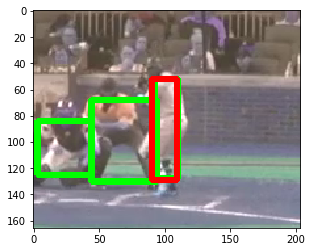

Frame 28
Overlaps (IoU): [0, 0.55954958856647896, 0, 0]


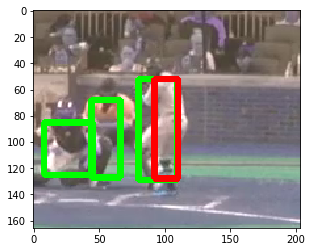

Frame 29
Overlaps (IoU): [0, 0, 0.92410901467505246, 0]


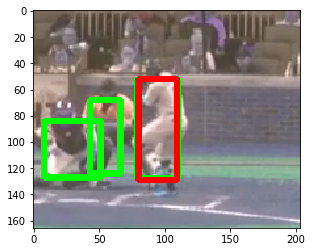

Frame 30
Overlaps (IoU): [0, 0.89242424242424245, 0, 0]


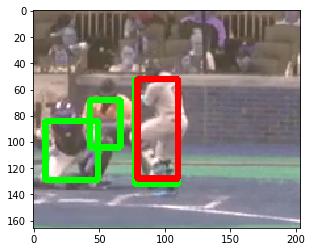

Frame 31
Overlaps (IoU): [0, 0.92436974789915971, 0, 0]


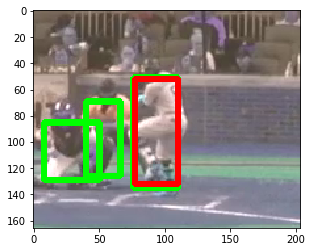

Frame 32
Overlaps (IoU): [0, 0, 0.90635340833884848, 0]


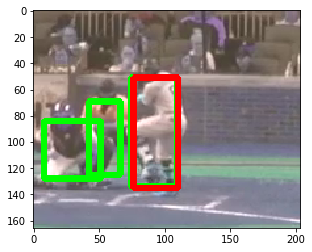

Frame 33
Overlaps (IoU): [0, 0, 0.97647058823529409, 0, 0, 0]


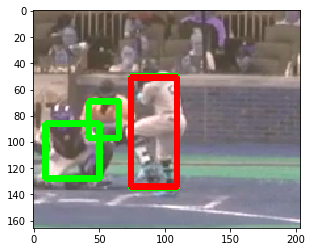

Frame 34
Overlaps (IoU): [0, 0, 0.9882352941176471, 0, 0]


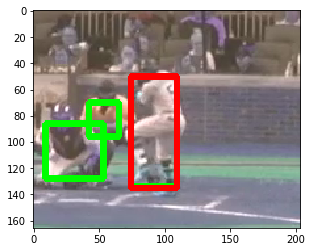

Frame 35
Overlaps (IoU): [0, 0, 0.92307692307692313, 0, 0]


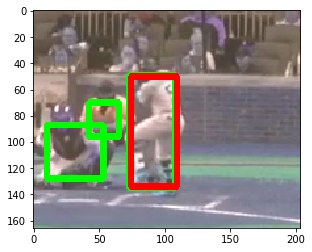

Frame 36
Overlaps (IoU): [0, 0, 0.93376413570274641, 0, 0, 0]


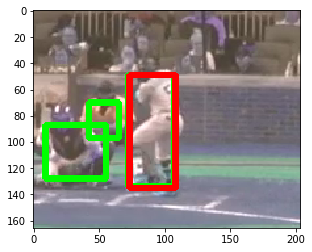

Frame 37
Overlaps (IoU): [0, 0, 0, 0.84019769357495877, 0, 0]


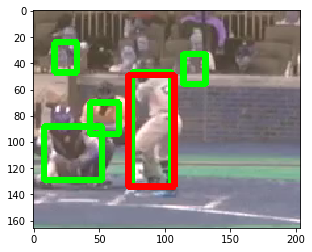

Frame 38
Overlaps (IoU): [0, 0, 0.82852807283763275, 0, 0]


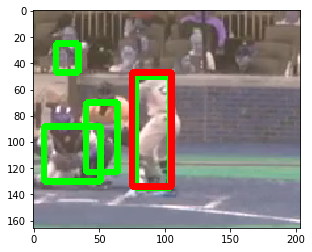

Frame 39
Overlaps (IoU): [0, 0, 0.81810035842293904, 0, 0]


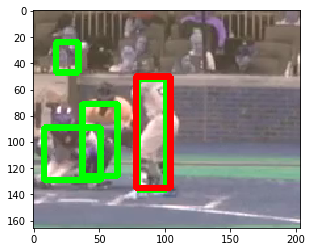

Frame 40
Overlaps (IoU): [0, 0, 0, 0, 0.89935760171306212]


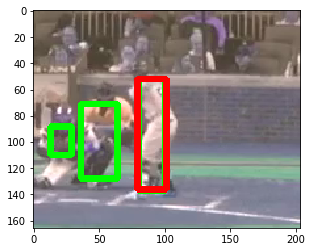

Frame 41
Overlaps (IoU): [0, 0, 0, 0, 0.88009313154831204, 0, 0]


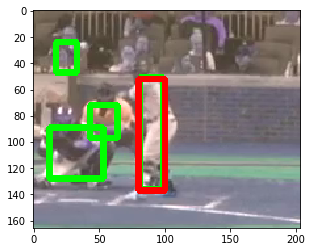

Frame 42
Overlaps (IoU): [0, 0, 0, 0.9154411764705882, 0]


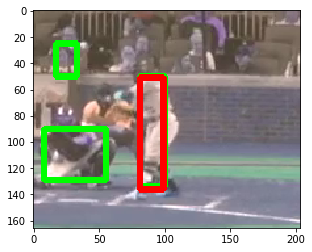

Frame 43
Overlaps (IoU): [0, 0, 0.8704663212435233, 0]


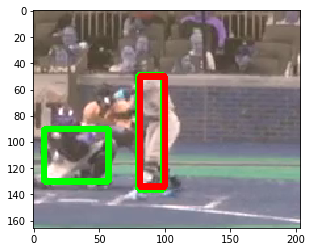

Frame 44
Overlaps (IoU): [0, 0, 0.77718960538979787, 0]


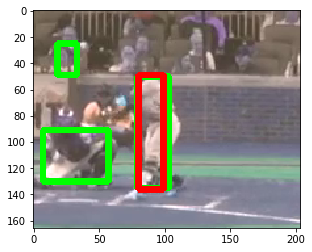

Frame 45
Overlaps (IoU): [0, 0.85747994336951394, 0, 0, 0, 0]


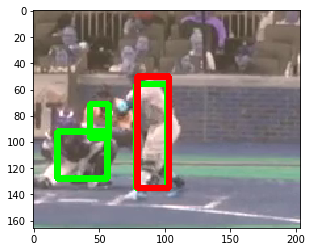

Frame 46
Overlaps (IoU): [0, 0, 0, 0, 0.81302325581395352]


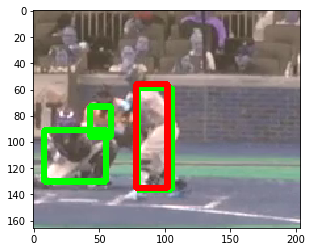

Frame 47
Overlaps (IoU): [0, 0, 0, 0, 0, 0.61677186654643823, 0]


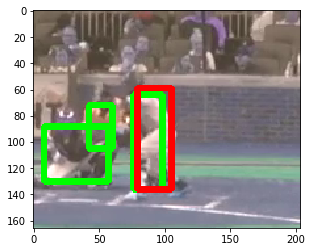

Frame 48
Overlaps (IoU): [0, 0, 0, 0.66774193548387095, 0, 0, 0, 0, 0.085858585858585856]


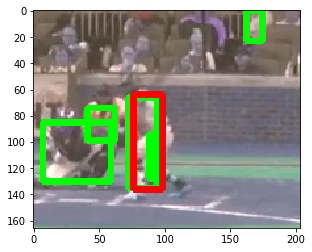

Frame 49
Overlaps (IoU): [0, 0, 0.71672354948805461, 0, 0, 0, 0, 0]


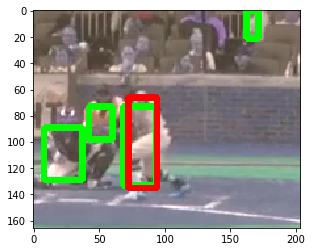

Frame 50
Overlaps (IoU): [0, 0, 0, 0, 0, 0, 0, 0.47522935779816516]


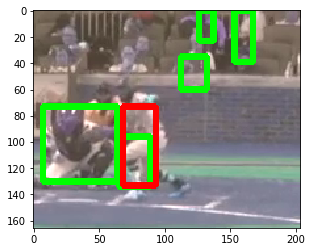

Frame 51
Overlaps (IoU): [0, 0.40764331210191085, 0, 0, 0, 0, 0.10028653295128939, 0]


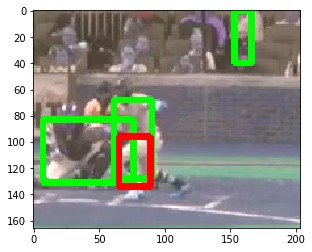

Frame 52
Overlaps (IoU): [0.73833097595473829, 0, 0, 0, 0, 0, 0, 0]


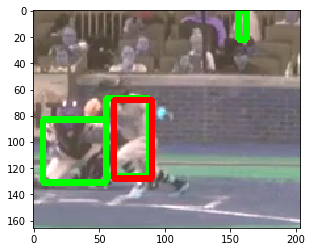

Frame 53
Overlaps (IoU): [0.84953395472703064, 0, 0, 0, 0, 0, 0, 0]


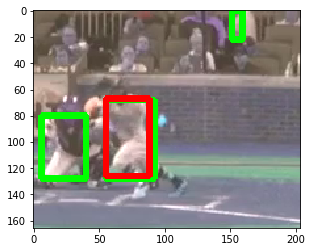

Frame 54
Overlaps (IoU): [0.76086956521739135, 0, 0, 0, 0, 0]


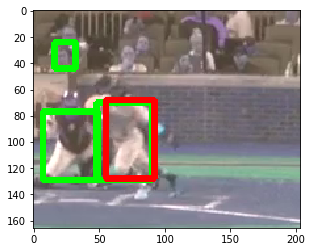

Frame 55
Overlaps (IoU): [0.7012824522990303, 0.011038961038961039, 0, 0, 0, 0]


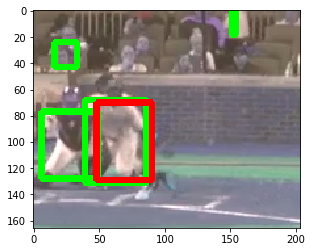

Frame 56
Overlaps (IoU): [0.96375124709012305, 0.044472952747487707, 0, 0, 0, 0, 0, 0]


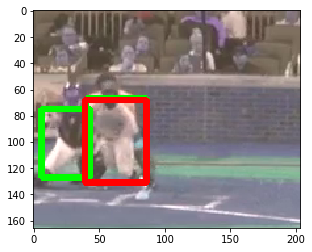

Frame 57
Overlaps (IoU): [0.84069293478260865, 0, 0, 0, 0, 0.50951086956521741, 0, 0, 0]
missing frame because of not enough or too many intersections with intersections: [0.84069293478260865, 0, 0, 0, 0, 0.50951086956521741, 0, 0, 0]


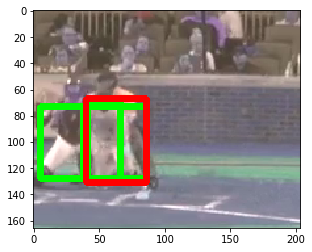

Frame 58
Overlaps (IoU): [0.30494135743126322, 0.53617412630288164, 0]


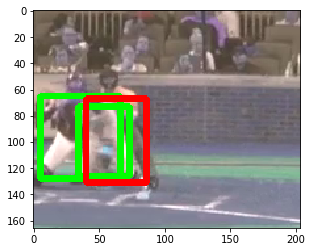

Frame 59
Overlaps (IoU): [0.36639615269011122, 0.14394350896252037, 0, 0]


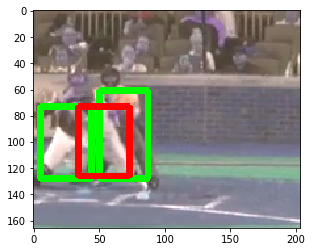

Frame 60
Overlaps (IoU): [0.020694115111015304, 0.90648627138877835, 0, 0, 0]


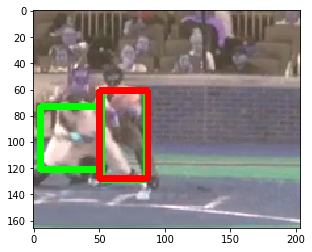

Frame 61
Overlaps (IoU): [0.747717281028069, 0, 0, 0, 0.05131578947368421, 0]


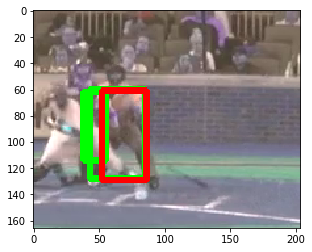

Frame 62
Overlaps (IoU): [0.070025083612040129, 0.72457216661285118, 0]


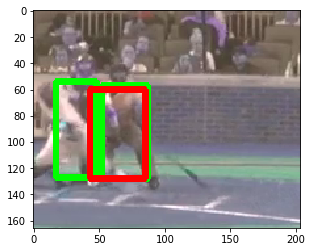

Frame 63
Overlaps (IoU): [0.84957264957264955, 0, 0, 0, 0]


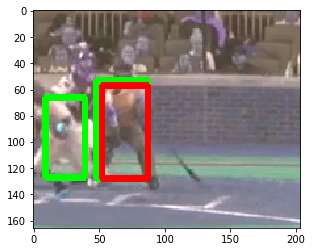

Frame 64
Overlaps (IoU): [0.8928571428571429, 0, 0, 0]


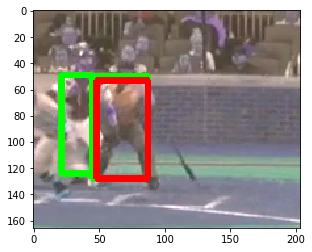

Frame 65
Overlaps (IoU): [0.95226730310262531, 0.0, 0]


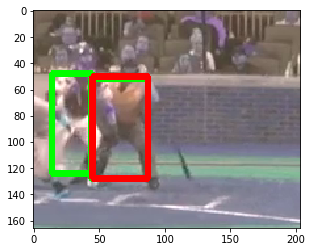

Frame 66
Overlaps (IoU): [0.012778386272362175, 0.9645808736717828, 0]


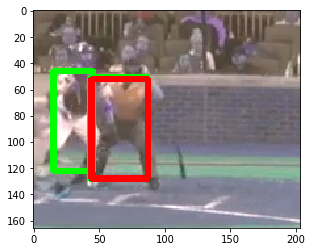

Frame 67
Overlaps (IoU): [0.012822828246342784, 0.95302390998593534, 0]


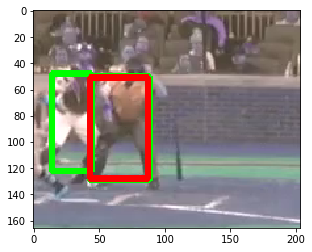

Frame 68
Overlaps (IoU): [0.012538646513225695, 0.95410628019323673, 0]


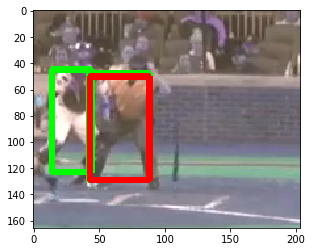

Frame 69
Overlaps (IoU): [0.025342465753424658, 0.96678775298391284, 0, 0]


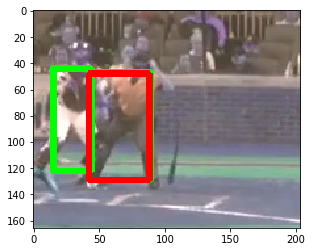

Frame 70
Overlaps (IoU): [0.92504387064427174, 0.012561060711793441, 0]


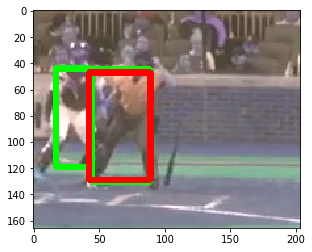

Frame 71
Overlaps (IoU): [0.92715231788079466, 0.011865864144453998, 0]


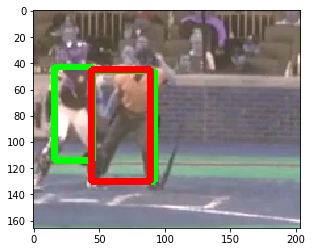

Frame 72
Overlaps (IoU): [0.86458333333333337, 0.0]


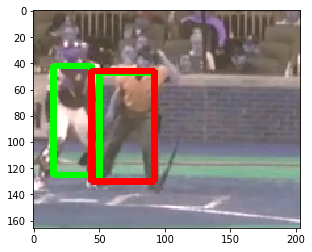

Frame 73
Overlaps (IoU): [0.88636363636363635, 0, 0]


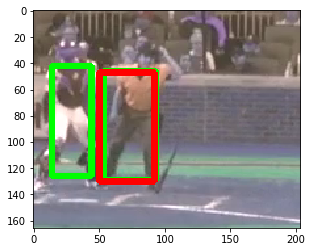

Frame 74
Overlaps (IoU): [0.8503130335799659, 0]


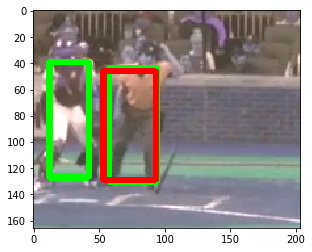

Frame 75
Overlaps (IoU): [0.87522713506965477, 0]


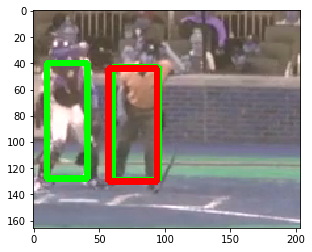

Frame 76
Overlaps (IoU): [0.84868421052631582, 0]


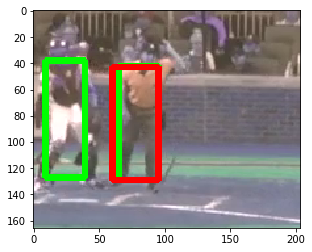

Frame 77
Overlaps (IoU): [0.9555555555555556, 0]


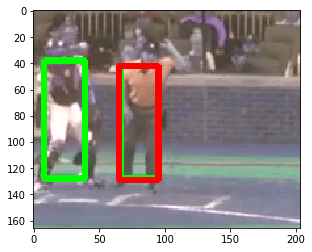

Frame 78
Overlaps (IoU): [0.88088012139605465, 0, 0, 0]


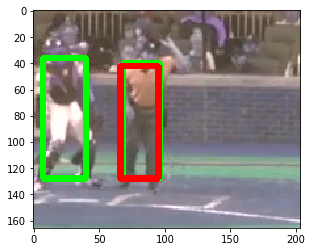

Frame 79
Overlaps (IoU): [0, 0.88388911209321008, 0]


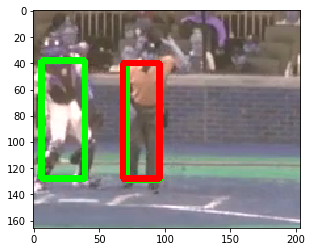

Frame 80
Overlaps (IoU): [0.90333618477331057, 0]


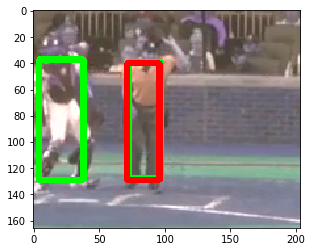

Frame 81
Overlaps (IoU): [0.91058718861209964, 0]


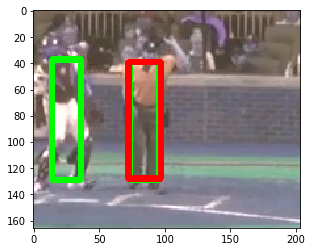

Frame 82
Overlaps (IoU): [0.90000000000000002, 0]


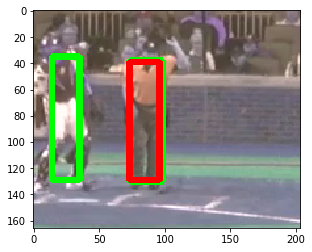

Frame 83
Overlaps (IoU): [0.95999999999999996, 0]


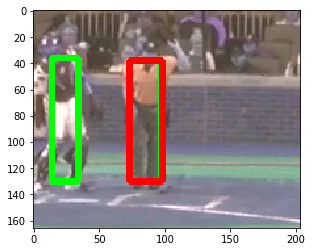

Frame 84
Overlaps (IoU): [0.9499782514136581, 0, 0]


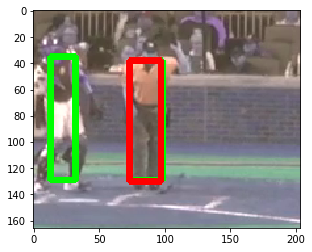

Frame 85
Overlaps (IoU): [0.93890109890109885, 0, 0]


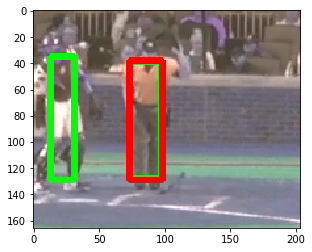

Frame 86
Overlaps (IoU): [0.95999999999999996, 0]


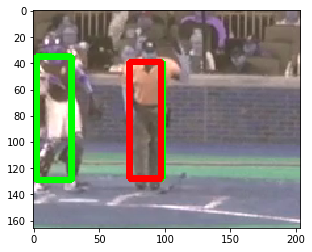

Frame 87
Overlaps (IoU): [0.98888888888888893, 0]


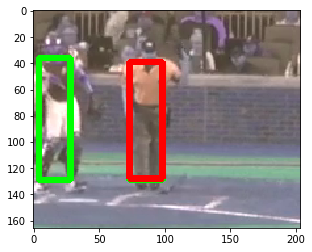

Frame 88
Overlaps (IoU): [0, 0.9097777777777778, 0]


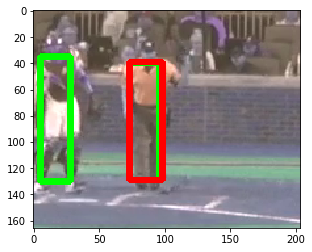

Frame 89
Overlaps (IoU): [0, 1.0, 0]


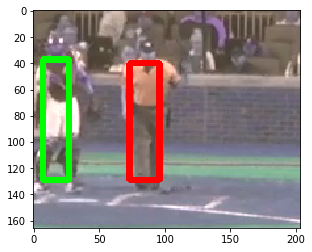

Frame 90
Overlaps (IoU): [0, 0.9376757263355201]


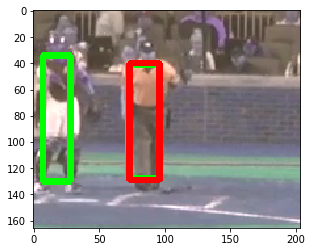

Frame 91
Overlaps (IoU): [0, 0.94789199431549032, 0, 0]


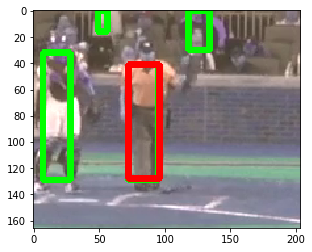

Frame 92
Overlaps (IoU): [0, 0.9887640449438202, 0, 0, 0]


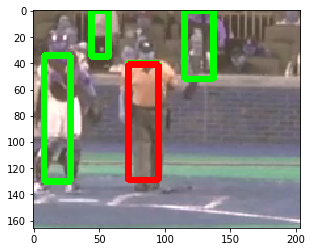

Frame 93
Overlaps (IoU): [0, 0.93747105141269105, 0, 0, 0]


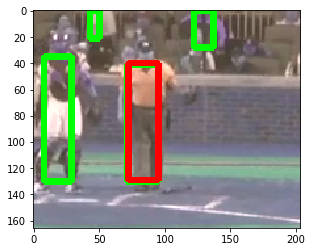

Frame 94
Overlaps (IoU): [1.0, 0, 0, 0, 0]


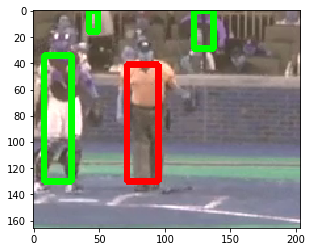

Frame 95
Overlaps (IoU): [0.94756554307116103, 0, 0, 0]


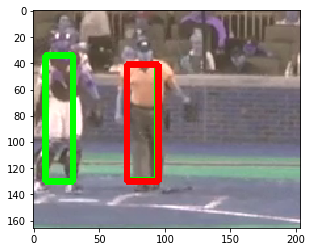

Frame 96
Overlaps (IoU): [0.94756554307116103, 0, 0, 0]


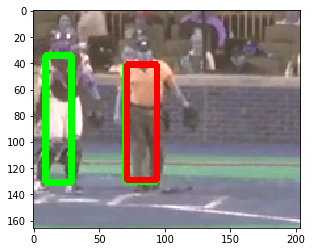

Frame 97
Overlaps (IoU): [0.90278951817413355, 0, 0]


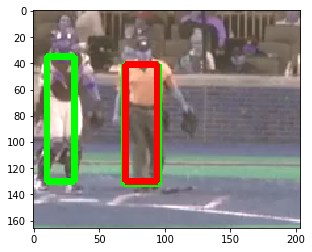

Frame 98
Overlaps (IoU): [0.94040574809805577, 0, 0, 0]


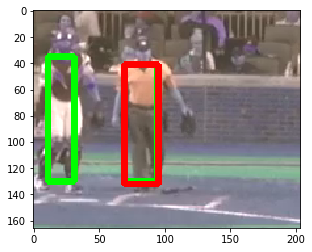

Frame 99
Overlaps (IoU): [0.96153846153846156, 0, 0]


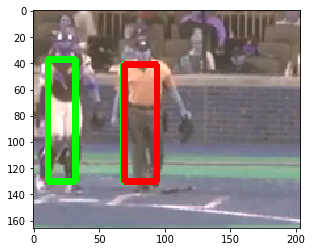

Frame 100
Overlaps (IoU): [0, 1.0, 0]


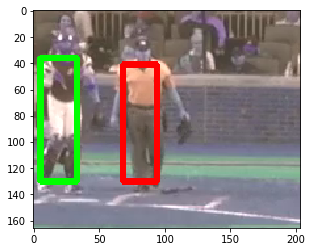

Frame 101
Overlaps (IoU): [0, 1.0, 0]


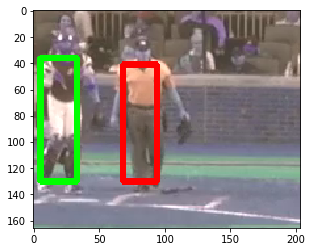

Frame 102
Overlaps (IoU): [0, 1.0, 0]


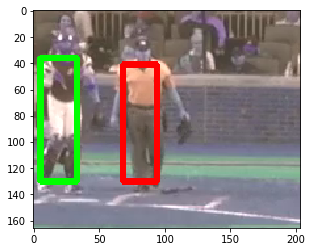

In [73]:
video_capture = cv2.VideoCapture(path_to_video)
video_capture.set(cv2.CAP_PROP_POS_FRAMES, START_VIDEO_AT_FRAME)

try:
    for i in open(path_to_ROI).readlines():
        datContent=ast.literal_eval(i)
    bottom_b=datContent[target_player]['bottom']
    left_b=datContent[target_player]['left']
    right_b=datContent[target_player]['right']
    top_b=datContent[target_player]['top']
    print("ROI:", bottom_b, left_b, right_b, top_b)
    TARGET_START_POSITION = np.array([abs(left_b-right_b)/2., abs(bottom_b-top_b)/2.]) # center of ROI
    ROI = True
except IOError:
    print("dat file exists:", os.path.exists(path_to_ROI))
    print("dat file not found", path_to_ROI)
    TARGET_START_POSITION = CENTER
    ROI = False
    
t=0
dic = {}
while True:
    # Capture frame-by-frame
    ret, frame = video_capture.read()
    if frame is None:
        break
    if ROI:
        frame = frame[top_b:bottom_b, left_b:right_b] # ROI
    try:
        # RUN POSE ESTIMATION
        coordinates = handle_one(frame)
        ### To show pose estimation output as sceletons, delete comments of the next three lines (and comment the line above)
        # canvas, coordinates = handle_one(frame, colour_image=True) 
        # print(canvas.shape)
        # plt.imshow(canvas)
        # plt.show()
    except ZeroDivisionError: # not sure why this occurs
        continue
    print("Frame", t+START_VIDEO_AT_FRAME)
    if t==0: # First frame: find the player whose hips are closest to the center of the ROI (or the manually specified center)
        dist_to_hips = []
        for person_detected in coordinates:
            hips = np.mean(np.asarray(person_detected)[[6,9]], axis=1)
            dist_to_hips.append(np.linalg.norm(hips- TARGET_START_POSITION))
        ind = np.argmin(dist_to_hips)
        target = coordinates[ind]
    else:
        out = player_localization(coordinates, target, frame) # Player localization of pose estimation output
        if not np.all(out==0): # only if the player is non-missing, the target is set to these joints,
            target = out       # otherwise the target for player localization stays the same
    dic["frame "+str(t)] = coordinates.tolist() # save all detected persons in dictionary
    t+=1
    

# Evaluation:

### In the example_1 video, the approach works perfectly well.
### In the example_2 video though, the target player is not detected in several consecutive frames (from frame 120 onwards), so another player is picked up. This can hardly be avoided because if pose estimation does not detect the player at all, it cannot be localized. It was tested that motion vectors also do not improve the results because usually the target player is simply not detected for too long.